In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import os
import torch
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

In [2]:
from hexarena.scripts.train_nets import create_manager

manager = create_manager('viktor', 0.1, 1000)


  0%|                                                                                                         …

In [3]:
keys = [key for key, _ in manager.completed()]

In [38]:
key = 'B705C5CB'
config = manager.configs[key]
config

{'subject': 'viktor',
 'num_samples': 1000,
 'update_kw': {'z_reg': 0.0001, 'num_epochs': 50},
 'model_kw': {'z_dim': 64},
 'seed': 2,
 'kappa': 0.1,
 'init_kw': {'z_reg': 0.0001, 'num_epochs': 200}}

In [23]:
manager.setup(config)

1

In [24]:
manager.load_ckpt(manager.ckpts[key])

1

In [28]:
observations = manager.observations
actions = manager.actions
beliefs = manager.beliefs

In [29]:
num_episodes = len(beliefs)
# split full observations and convert to tensors
assert len(observations)==num_episodes
k_tensors = [[] for _ in range(num_episodes)]
o_tensors = [[] for _ in range(num_episodes)]
for i in range(num_episodes):
    for observation in observations[i]:
        k, o = manager.model.split_observation(observation)
        k_tensors[i].append(manager.model._k_tensor(k))
        o_tensors[i].append(manager.model._o_tensor(o))
    k_tensors[i] = torch.stack(k_tensors[i])
    o_tensors[i] = torch.stack(o_tensors[i])
# convert actions to tensors
assert len(actions)==num_episodes
a_tensors = []
for i in range(len(actions)):
    a_tensors.append(torch.stack([
        manager.model._a_tensor(action) for action in actions[i]
    ]))
# remove gradient information if any
beliefs = [beliefs[i].data for i in range(num_episodes)]

In [30]:
k_t = torch.cat([k_tensors[i][:-1] for i in range(num_episodes)])
b_t = torch.cat([beliefs[i][:-1] for i in range(num_episodes)])
a_t = torch.cat(a_tensors)
k_tp1 = torch.cat([k_tensors[i][1:] for i in range(num_episodes)])
o_tp1 = torch.cat([o_tensors[i][1:] for i in range(num_episodes)])
b_tp1 = torch.cat([beliefs[i][1:] for i in range(num_episodes)])

In [34]:
with torch.no_grad():
    *_, preds = manager.model.update_net(
        torch.cat([k_t, b_t, a_t, k_tp1, o_tp1], dim=1),
    )
kl_losses = []
for i in range(len(preds)):
    d, ent = manager.model.update_net.p_x.kl_divergence(b_tp1[i], preds[i])
    kl_losses.append(d)
kl_losses = torch.stack(kl_losses)

In [36]:
kl_losses.mean()

tensor(5.5765)

In [37]:
config

{'subject': 'viktor',
 'num_samples': 1000,
 'update_kw': {'num_epochs': 300, 'z_reg': 0.0001},
 'seed': 0,
 'kappa': 0.1,
 'init_kw': {'z_reg': 0.0001, 'num_epochs': 200},
 'model_kw': {'z_dim': 8}}

In [18]:
from jarvis.utils import array2tensor

ckpt = array2tensor(manager.ckpts[key])
ckpt.keys()

dict_keys(['state_dict', 'stats_u', 'stats_i'])

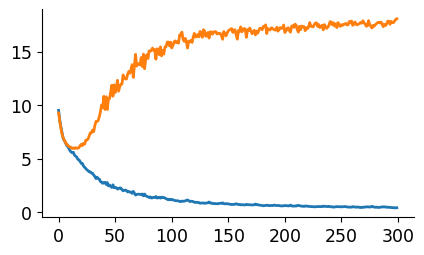

In [22]:
losses_train = ckpt['stats_u']['losses_train'][:, 0]
losses_val = ckpt['stats_u']['losses_val'][:, 0]
_, ax = plt.subplots()
ax.plot(losses_train)
ax.plot(losses_val)
plt.show()

In [8]:
observations = manager.observations
actions = manager.actions
beliefs = manager.beliefs
strict_init = True
update_kw = manager.train_kw['update_kw']
init_kw = manager.train_kw['init_kw']

num_episodes = len(beliefs)
# split full observations and convert to tensors
assert len(observations)==num_episodes
k_tensors = [[] for _ in range(num_episodes)]
o_tensors = [[] for _ in range(num_episodes)]
for i in range(num_episodes):
    for observation in observations[i]:
        k, o = manager.model.split_observation(observation)
        k_tensors[i].append(manager.model._k_tensor(k))
        o_tensors[i].append(manager.model._o_tensor(o))
    k_tensors[i] = torch.stack(k_tensors[i])
    o_tensors[i] = torch.stack(o_tensors[i])
# convert actions to tensors
assert len(actions)==num_episodes
a_tensors = []
for i in range(len(actions)):
    a_tensors.append(torch.stack([
        manager.model._a_tensor(action) for action in actions[i]
    ]))
# remove gradient information if any
beliefs = [beliefs[i].data for i in range(num_episodes)]

In [10]:
if strict_init: # only the first time step of each episode is used
    k_0 = torch.stack([k_tensors[i][0] for i in range(num_episodes)])
    o_0 = torch.stack([o_tensors[i][0] for i in range(num_episodes)])
    b_0 = torch.stack([beliefs[i][0] for i in range(num_episodes)])
else:
    k_0 = torch.cat(k_tensors)
    o_0 = torch.cat(o_tensors)
    b_0 = torch.cat(beliefs)
stats_i = manager.model.init_net.regress(
    b_0, torch.cat([k_0, o_0], dim=1), train_decoder=False, **init_kw,
)

  0%|                                                                                                         …

In [ ]:
from jarvis.utils import array2tensor

ckpt = array2tensor(manager.ckpts[key])

In [17]:
init_kw

{'num_epochs': 200, 'z_reg': 0.0001}

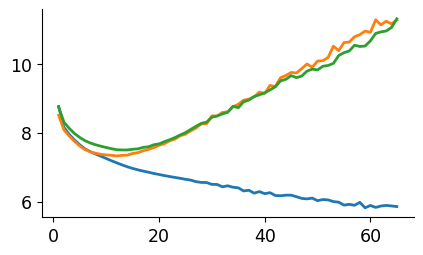

In [12]:
_, ax = plt.subplots()
n_epochs = len(ckpt['losses']['train'])
ax.plot(np.arange(n_epochs)+1, ckpt['losses']['train'])
ax.plot(np.arange(n_epochs)+1, ckpt['losses']['val'])
ax.plot(np.arange(n_epochs)+1, ckpt['losses']['test'])
plt.show()

In [3]:
from hexarena.scripts.train_nets import fetch_best_net

subject = 'marco'
config, model = fetch_best_net(subject, kappa, num_samples)

In [4]:
config

{'init_kw': {'num_epochs': 200, 'z_reg': 0.0001},
 'kappa': 0.1,
 'num_samples': 1000,
 'subject': 'marco',
 'model_kw': {'z_dim': 32},
 'seed': 5,
 'update_kw': {'num_epochs': 300, 'z_reg': 0.0001}}

In [13]:
from jarvis.utils import array2tensor

ckpt = array2tensor(manager.ckpts[key])
ckpt.keys()

dict_keys(['losses', 'min_loss', 'best_state', 'last_state'])

In [15]:
manager.setup(config)
manager.load_ckpt(manager.ckpts[key])

Fetching beliefs:   0%|                                                                                       …

14

In [38]:
beliefs_train = torch.cat([manager.beliefs[i] for i in manager.idxs['train']])
manager.belief_vae.rng = np.random.default_rng(manager.seed) # reset train/val split
stats = manager.belief_vae.regress(
    beliefs_train, beliefs_train, num_epochs=10,
    pbar_kw={'disable': False}, **manager.regress_kw,
)

  0%|                                                                                                         …

In [26]:
stats.keys()

dict_keys(['reg_coefs', 'alphas', 'split', 'batch_size', 'num_epochs', 'losses_train', 'losses_val', 'steps', 't_train', 'queries', 'fits', 'optimality', 'fvu', 'lr', 'momentum'])

In [40]:
stats['losses_train'][:, 0]

array([7.234524 , 7.2044373, 7.0157027, 6.928103 , 6.8271475, 6.795452 ,
       6.8114376, 6.79072  , 6.7339153, 6.738489 ], dtype=float32)

In [42]:
beliefs_test = torch.cat([manager.beliefs[i] for i in manager.idxs['test']])
with torch.no_grad():
    _, _, recons = manager.belief_vae(beliefs_test)
kl_losses, _ = zip(*[
    manager.belief_vae.p_x.kl_divergence(beliefs_test[i], recons[i])
    for i in range(len(recons))
])

In [8]:
from jarvis.utils import array2tensor

key = keys[0]
config = manager.configs[key]
ckpt = array2tensor(manager.ckpts[key])

In [10]:
ckpt['workspace'].keys()

dict_keys(['pis', 'As', 'lls', 'gammas', 'log_Zs', 'log_gammas', 'log_xis'])

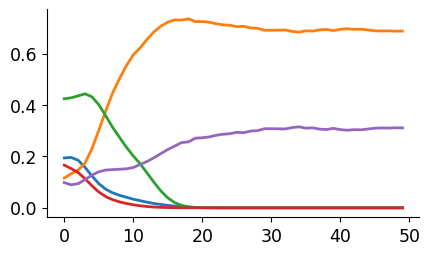

In [16]:
_, ax = plt.subplots()
ax.plot(torch.stack(ckpt['workspace']['pis']))
plt.show()

In [4]:
manager.setup(config)

inf

In [5]:
manager.reset()

In [11]:
manager.step()

  0%|                                                                                                         …

In [12]:
ckpt = manager.get_ckpt()

In [14]:
manager.load_ckpt(ckpt)

1

In [16]:
config.policy

{'num_features': [], 'nonlinearity': 'Softplus'}

In [15]:
config.reg_coefs

{'alpha_A': 100.0, 'off_ratio': 0.1, 'l2_reg': 0.001, 'ent_reg': 0.0001}

In [2]:
from hexarena.scripts.common import get_block_ids, create_env_and_model

subject, kappa, num_samples = 'marco', 0.1, 1000
num_macros = 10
env, model = create_env_and_model(subject, kappa)
block_ids = get_block_ids(subject, kappa)

In [3]:
from hexarena.scripts.compute_beliefs import fetch_beliefs

knowns, beliefs, actions = [], [], []
for session_id, block_idx in tqdm(block_ids, desc='Collect data', unit='block', leave=True):
    _, _actions, _knowns, _beliefs = fetch_beliefs(
        subject, kappa, num_samples, session_id, block_idx,
    )
    _actions = env.monkey.merge_actions(_actions, num_macros)
    knowns.append(torch.tensor(_knowns, dtype=torch.float)[:-1])
    beliefs.append(_beliefs[:-1])
    actions.append(torch.tensor(_actions, dtype=torch.long))

Collect data:   0%|                                                                                           …

In [4]:
from hexarena.scripts.compress_beliefs import fetch_best_vae

z_dim = 4
config, belief_vae = fetch_best_vae(subject, kappa, num_samples, z_dim)

In [5]:
config

{'z_dim': 4,
 'subject': 'marco',
 'kappa': 0.1,
 'regress_kw': {'train_encoder': True,
  'l2_reg': 0.001,
  'ent_reg': 0.0001,
  'lr': 0.005,
  'z_reg': 0.01,
  'momentum': 0.9,
  'train_decoder': True},
 'split': 0.95,
 'num_samples': 1000,
 'seed': 2,
 'vae_kw': {'encoder': None, 'decoder': None}}

In [11]:
from irc.hmp import HiddenMarkovPolicy

z_dim = 4
num_policies = 3
policy = {
    'num_features': [], 'nonlinearity': 'Softplus',
}

hmp = HiddenMarkovPolicy(
    model.p_s, z_dim, num_macros, num_policies=num_policies,
    ebd_k=model.ebd_k, ebd_b=model.ebd_b, policy=policy,
)

In [15]:
hmp.reset(0)

In [ ]:
stats = hmp.train_belief_vae(torch.cat(beliefs), seed=0)